In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import corner
from sklearn.model_selection import train_test_split
from astroML.utils import completeness_contamination
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("C:/Users/leoni/Desktop/astrostatistics_bicocca_2024/solutions/galaxyquasar.csv")

In [3]:
le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
data['class'] = le.fit_transform(data['class'])
labels = le.inverse_transform(data['class'])
class_names = le.classes_
#così adesso i QSO hanno label=1 e gal hanno label=0

In [4]:
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,1,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,0,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,0,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,0,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,1,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,0,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,0,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,0,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,0,0.112571,0.000009


In [5]:
rows_with_nan = data[data.isnull().any(axis=1)]
print(rows_with_nan)
#non ci sono Nan

Empty DataFrame
Columns: [u, g, r, i, z, class, z1, zerr]
Index: []


In [6]:
u=data['u']
g=data['g']
r=data['r']
i=data['i']
z=data['z']
labels=data['class']

u=np.array(u)
g=np.array(g)
r=np.array(r)
i=np.array(i)
z=np.array(z)
labels=np.array(labels)

u_g=u-g
g_r=g-r
r_i=r-i
i_z=i-z

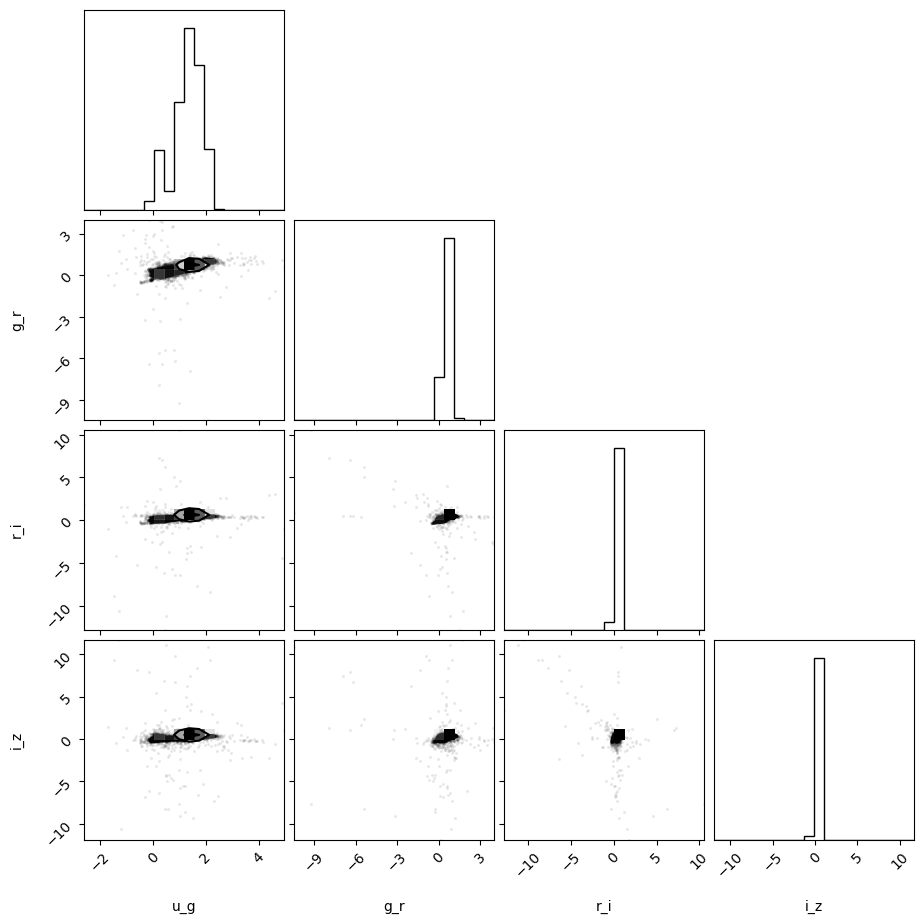

In [7]:
colori=np.column_stack((u_g, g_r, r_i,i_z))

nomi = ["u_g","g_r", "r_i", "i_z"]

fig = corner.corner(colori, labels=nomi)

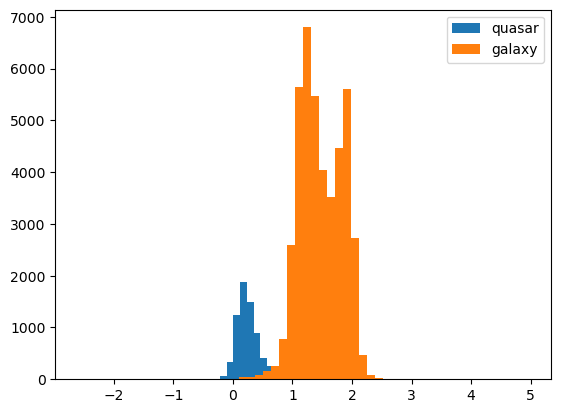

In [8]:
u_gQSO=u_g[labels==1]
u_gGAL=u_g[labels==0]
plt.hist(u_gQSO, bins=50, label="quasar")
plt.hist(u_gGAL, bins=50, label="galaxy")
plt.legend()
plt.show()


In [19]:
scaler = StandardScaler()
colori_stand = scaler.fit_transform(colori)

Xtrain, Xtest, ytrain, ytest = train_test_split(colori_stand, labels, test_size=0.33, random_state=42)

In [20]:
Xtrain.shape

(33500, 4)

In [21]:
from sklearn.neural_network import MLPClassifier

In [22]:
clf = MLPClassifier(hidden_layer_sizes=(5), 
                    activation='relu',
                    solver='adam',
                    learning_rate_init=0.001,
                    max_iter=200)

clf.fit(Xtrain[:1000], ytrain[:1000]) 

C:\Users\leoni\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=5)

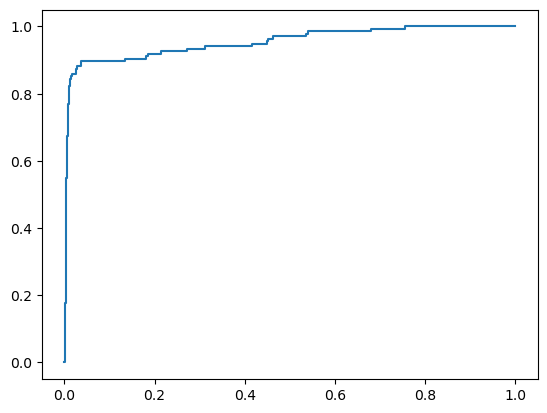

train accuracy:  0.968
test accuracy:  0.965


In [23]:
y_prob = clf.predict_proba(Xtest[:1000])[:, 1]
ypred = clf.predict(Xtest[:1000])

fpr, tpr, thresholds = roc_curve(ytest[:1000], y_prob) 

plt.plot(fpr, tpr)
plt.show()

cm_test=confusion_matrix(ytest[:1000], ypred)
test_accuracy=np.trace(cm_test) / np.sum(cm_test)

ypred_train = clf.predict(Xtrain[:1000])
cm_train=confusion_matrix(ytrain[:1000], ypred_train)
train_accuracy=np.trace(cm_train) / np.sum(cm_train)

print("train accuracy: ", train_accuracy)
print("test accuracy: ", test_accuracy)

In [24]:
#ci mette un paio di minuti
from sklearn.model_selection import RepeatedStratifiedKFold

mlp = MLPClassifier(solver='adam', random_state=42)

#faccio cross validation 10 volte così ottengo una stima più robusta dei parametri

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (5, 5), (10, 10)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 400, 600]
}

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

grid_search.fit(Xtrain[:1000], ytrain[:1000])

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'activation': 'tanh', 'hidden_layer_sizes': (5, 5), 'learning_rate_init': 0.01, 'max_iter': 200}


In [25]:
best_mpl=grid_search.best_estimator_

In [26]:
#faccio il fit su tutti i training data 
best_mpl.fit(Xtrain, ytrain)

MLPClassifier(activation='tanh', hidden_layer_sizes=(5, 5),
              learning_rate_init=0.01, random_state=42)

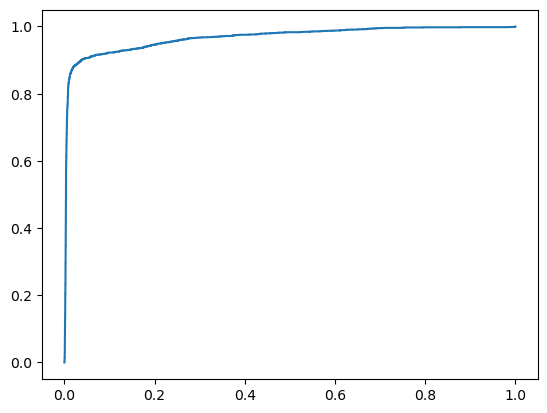

train accuracy:  0.9623880597014925
test accuracy:  0.9668484848484848


In [29]:
y_prob = clf.predict_proba(Xtest)[:, 1]
ypred = clf.predict(Xtest)

fpr, tpr, thresholds = roc_curve(ytest, y_prob)  

plt.plot(fpr, tpr)
plt.show()

cm_test=confusion_matrix(ytest, ypred)
test_accuracy=np.trace(cm_test) / np.sum(cm_test)

ypred_train = clf.predict(Xtrain)
cm_train=confusion_matrix(ytrain, ypred_train)
train_accuracy=np.trace(cm_train) / np.sum(cm_train)

print("train accuracy: ", train_accuracy)
print("test accuracy: ", test_accuracy)


#classification senza neural avevo trovato compl=0.92 e cont=0.05. Ora è un po' migliorato ma non così tanto